# Проект: классификация

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots


## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [121]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [123]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
display(df.isnull().sum()/len(df)*100)
df['balance'].isnull().value_counts()

age          0.000000
job          0.000000
marital      0.000000
education    0.000000
default      0.000000
balance      0.223974
housing      0.000000
loan         0.000000
contact      0.000000
day          0.000000
month        0.000000
duration     0.000000
campaign     0.000000
pdays        0.000000
previous     0.000000
poutcome     0.000000
deposit      0.000000
dtype: float64

balance
False    11137
True        25
Name: count, dtype: int64

### Задание 2

In [124]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [125]:
df['balance'].head()

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object

In [126]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].replace({r'\$': '', ',': '.', ' ':''}, regex=True)
df['balance'] = df['balance'].astype(float)

# Вычесляем среднее по приобразованному признаку balance
round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [127]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
median_value = df['balance'].median()
df['balance'].fillna(median_value, inplace=True)

round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [128]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
# Выяним моду у столбцов job и education
popular_job = df['job'].mode()[0]
popular_education = df['education'].mode()[0]

# Заменим unknown в столбцах на значение моды
df['job'] = df['job'].replace({r'unknown':'management'}, regex=True)
df['education'] = df['education'].replace({r'unknown':'secondary'}, regex=True)

# рассчитаем средний баланс клиентов с самой популярной работой и самым популярным образованием
average_balance = df.loc[
    (df['job'] == popular_job) & (df['education'] == popular_education),
    'balance'
].mean()

average_balance_rounded = round(average_balance, 3)

average_balance_rounded


1598.883

### Задание 6

In [129]:
# удалите все выбросы для признака balance
# ваш код
# найдем 25-й и 75-й перцентиль
x = df['balance']
q1 = np.percentile(x, 25)
q3 = np.percentile(x, 75)
# Межквартильный размах
iqr = q3 - q1
# Найдем нижнюю и верхнюю границы 
lower_bound = (q1 - (iqr*1.5))
upper_bound = (q3 + (iqr*1.5))

print('25-й перцентиль: {}'.format(q1),
      '75-й перцентиль: {}'.format(q3),
      'IQR: {}'.format(iqr),
      'Границы выбрасов: ({lb}, {up})'.format(lb=lower_bound, up=upper_bound))

# Анализ выбросов методом Тьюки (нестрогое неравенство)
df_nb = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]
df_nb.shape

25-й перцентиль: 123.0 75-й перцентиль: 1699.0 IQR: 1576.0 Границы выбрасов: (-2241.0, 4063.0)


(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

In [130]:
df_nb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


deposit
no     5424
yes    4681
Name: count, dtype: int64

Text(0.5, 1.0, 'Сбалансированность классов в данных')

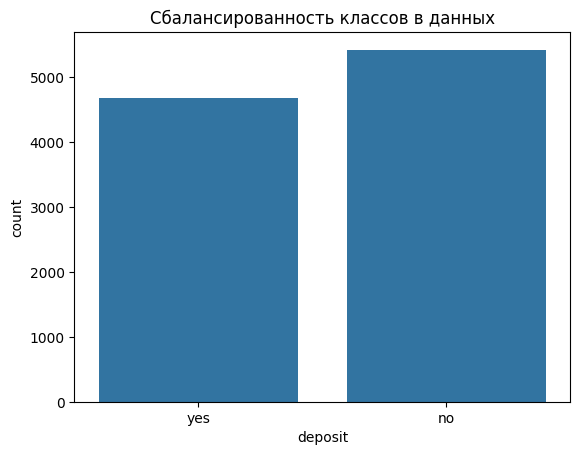

In [131]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
display(df_nb['deposit'].value_counts())
sns.countplot(
    data=df_nb,
    x='deposit'
)
plt.title('Сбалансированность классов в данных')

### Задания 2 и 3

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


<Figure size 640x480 with 0 Axes>

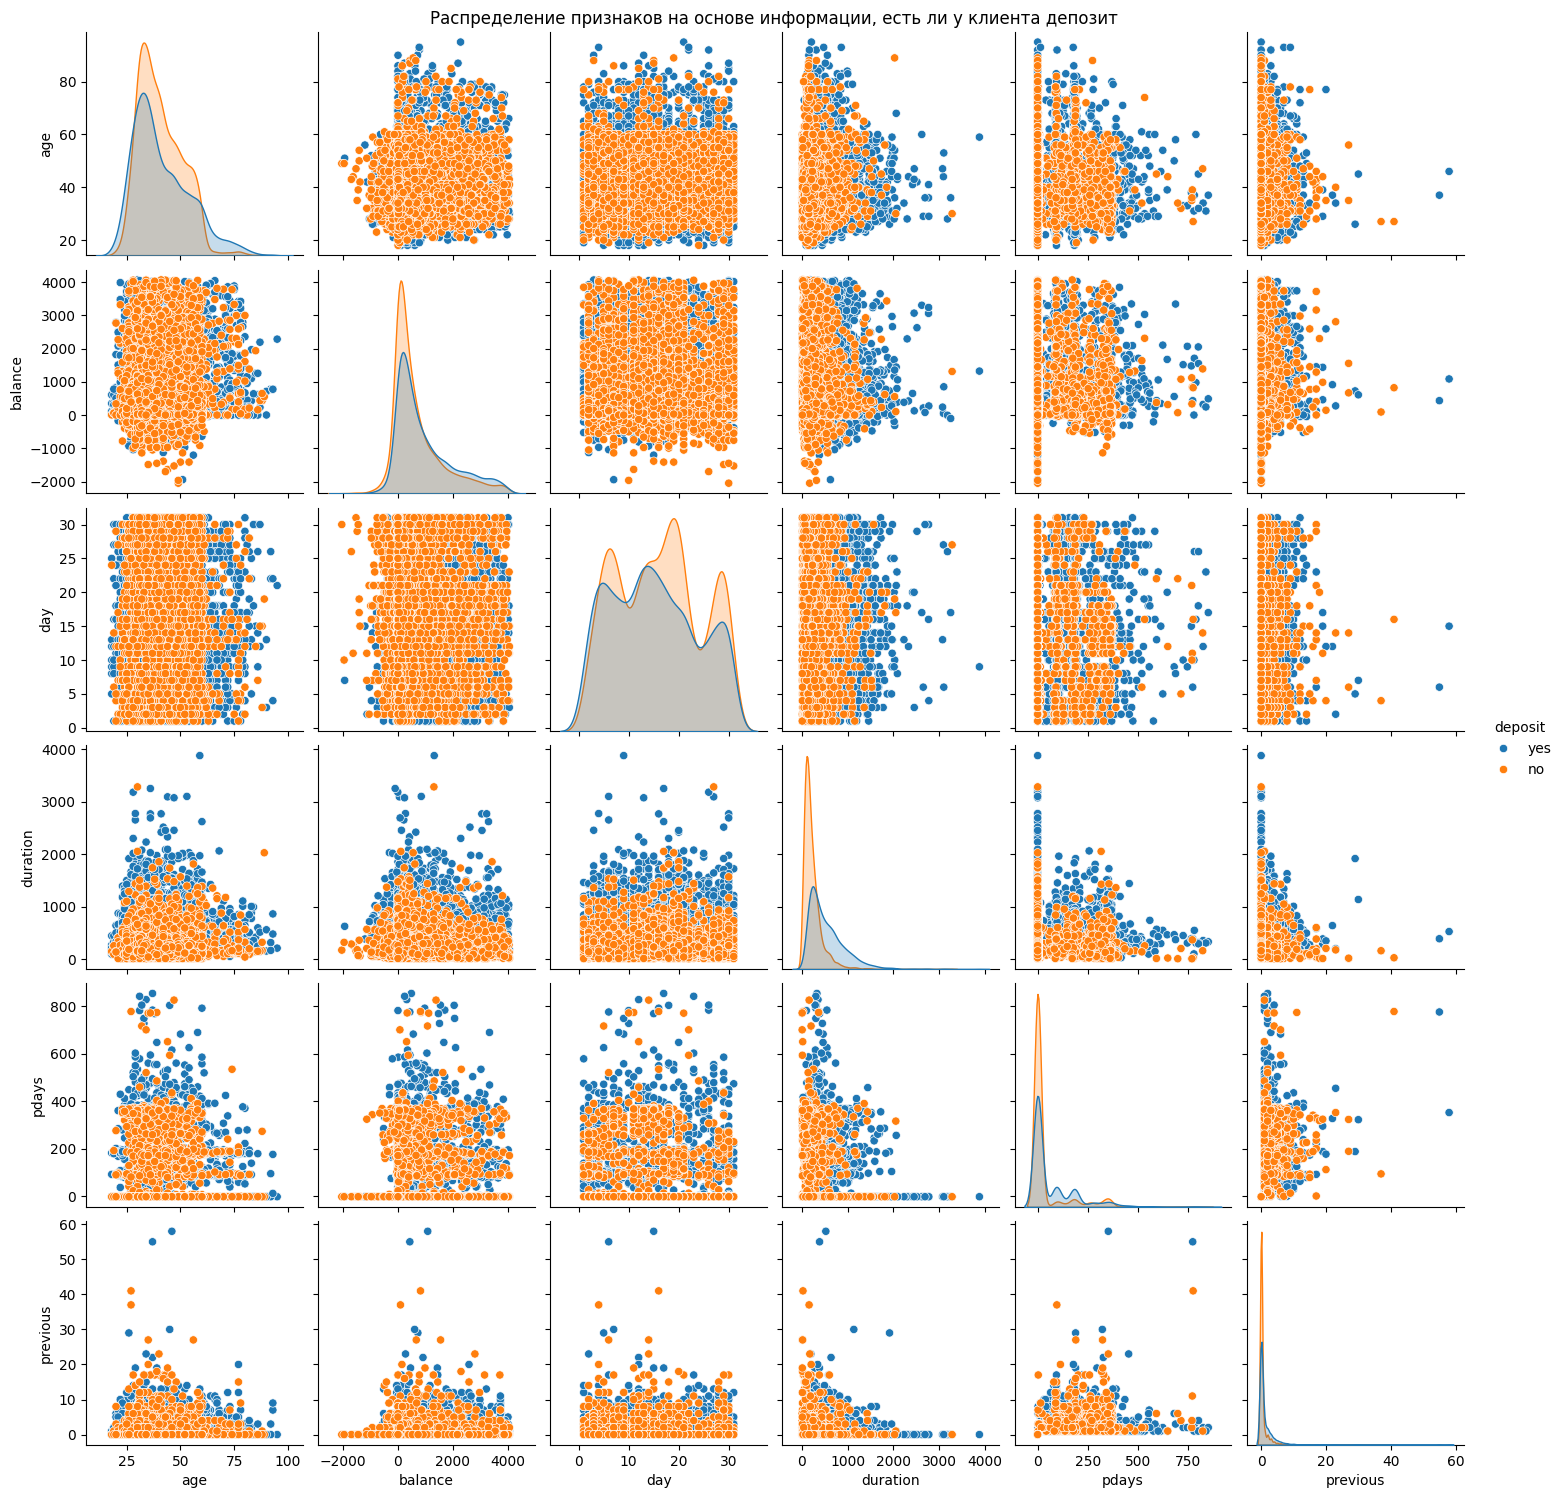

In [132]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
display(df_nb.describe())

to_plot = ['age', 'balance', 'day', 'duration', 'pdays', 'previous', 'deposit']
plt.figure()
sns.pairplot(df_nb[to_plot], hue='deposit')
plt.suptitle(
    'Распределение признаков на основе информации, есть ли у клиента депозит',
    y=1
)
plt.show();

### Задания 4 и 5

Количество сфер занятости клиентов: 11
месяцы в которые проводилась маркетинговая компания: month
may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb     709
oct     335
jan     319
sep     278
mar     237
dec      93
Name: count, dtype: int64
Cемейное положение клиентов: marital
married     5715
single      3213
divorced    1177
Name: count, dtype: int64
Образование клиентов: education
secondary    5517
tertiary     3239
primary      1349
Name: count, dtype: int64
Средний возраст клиентов: 41.0


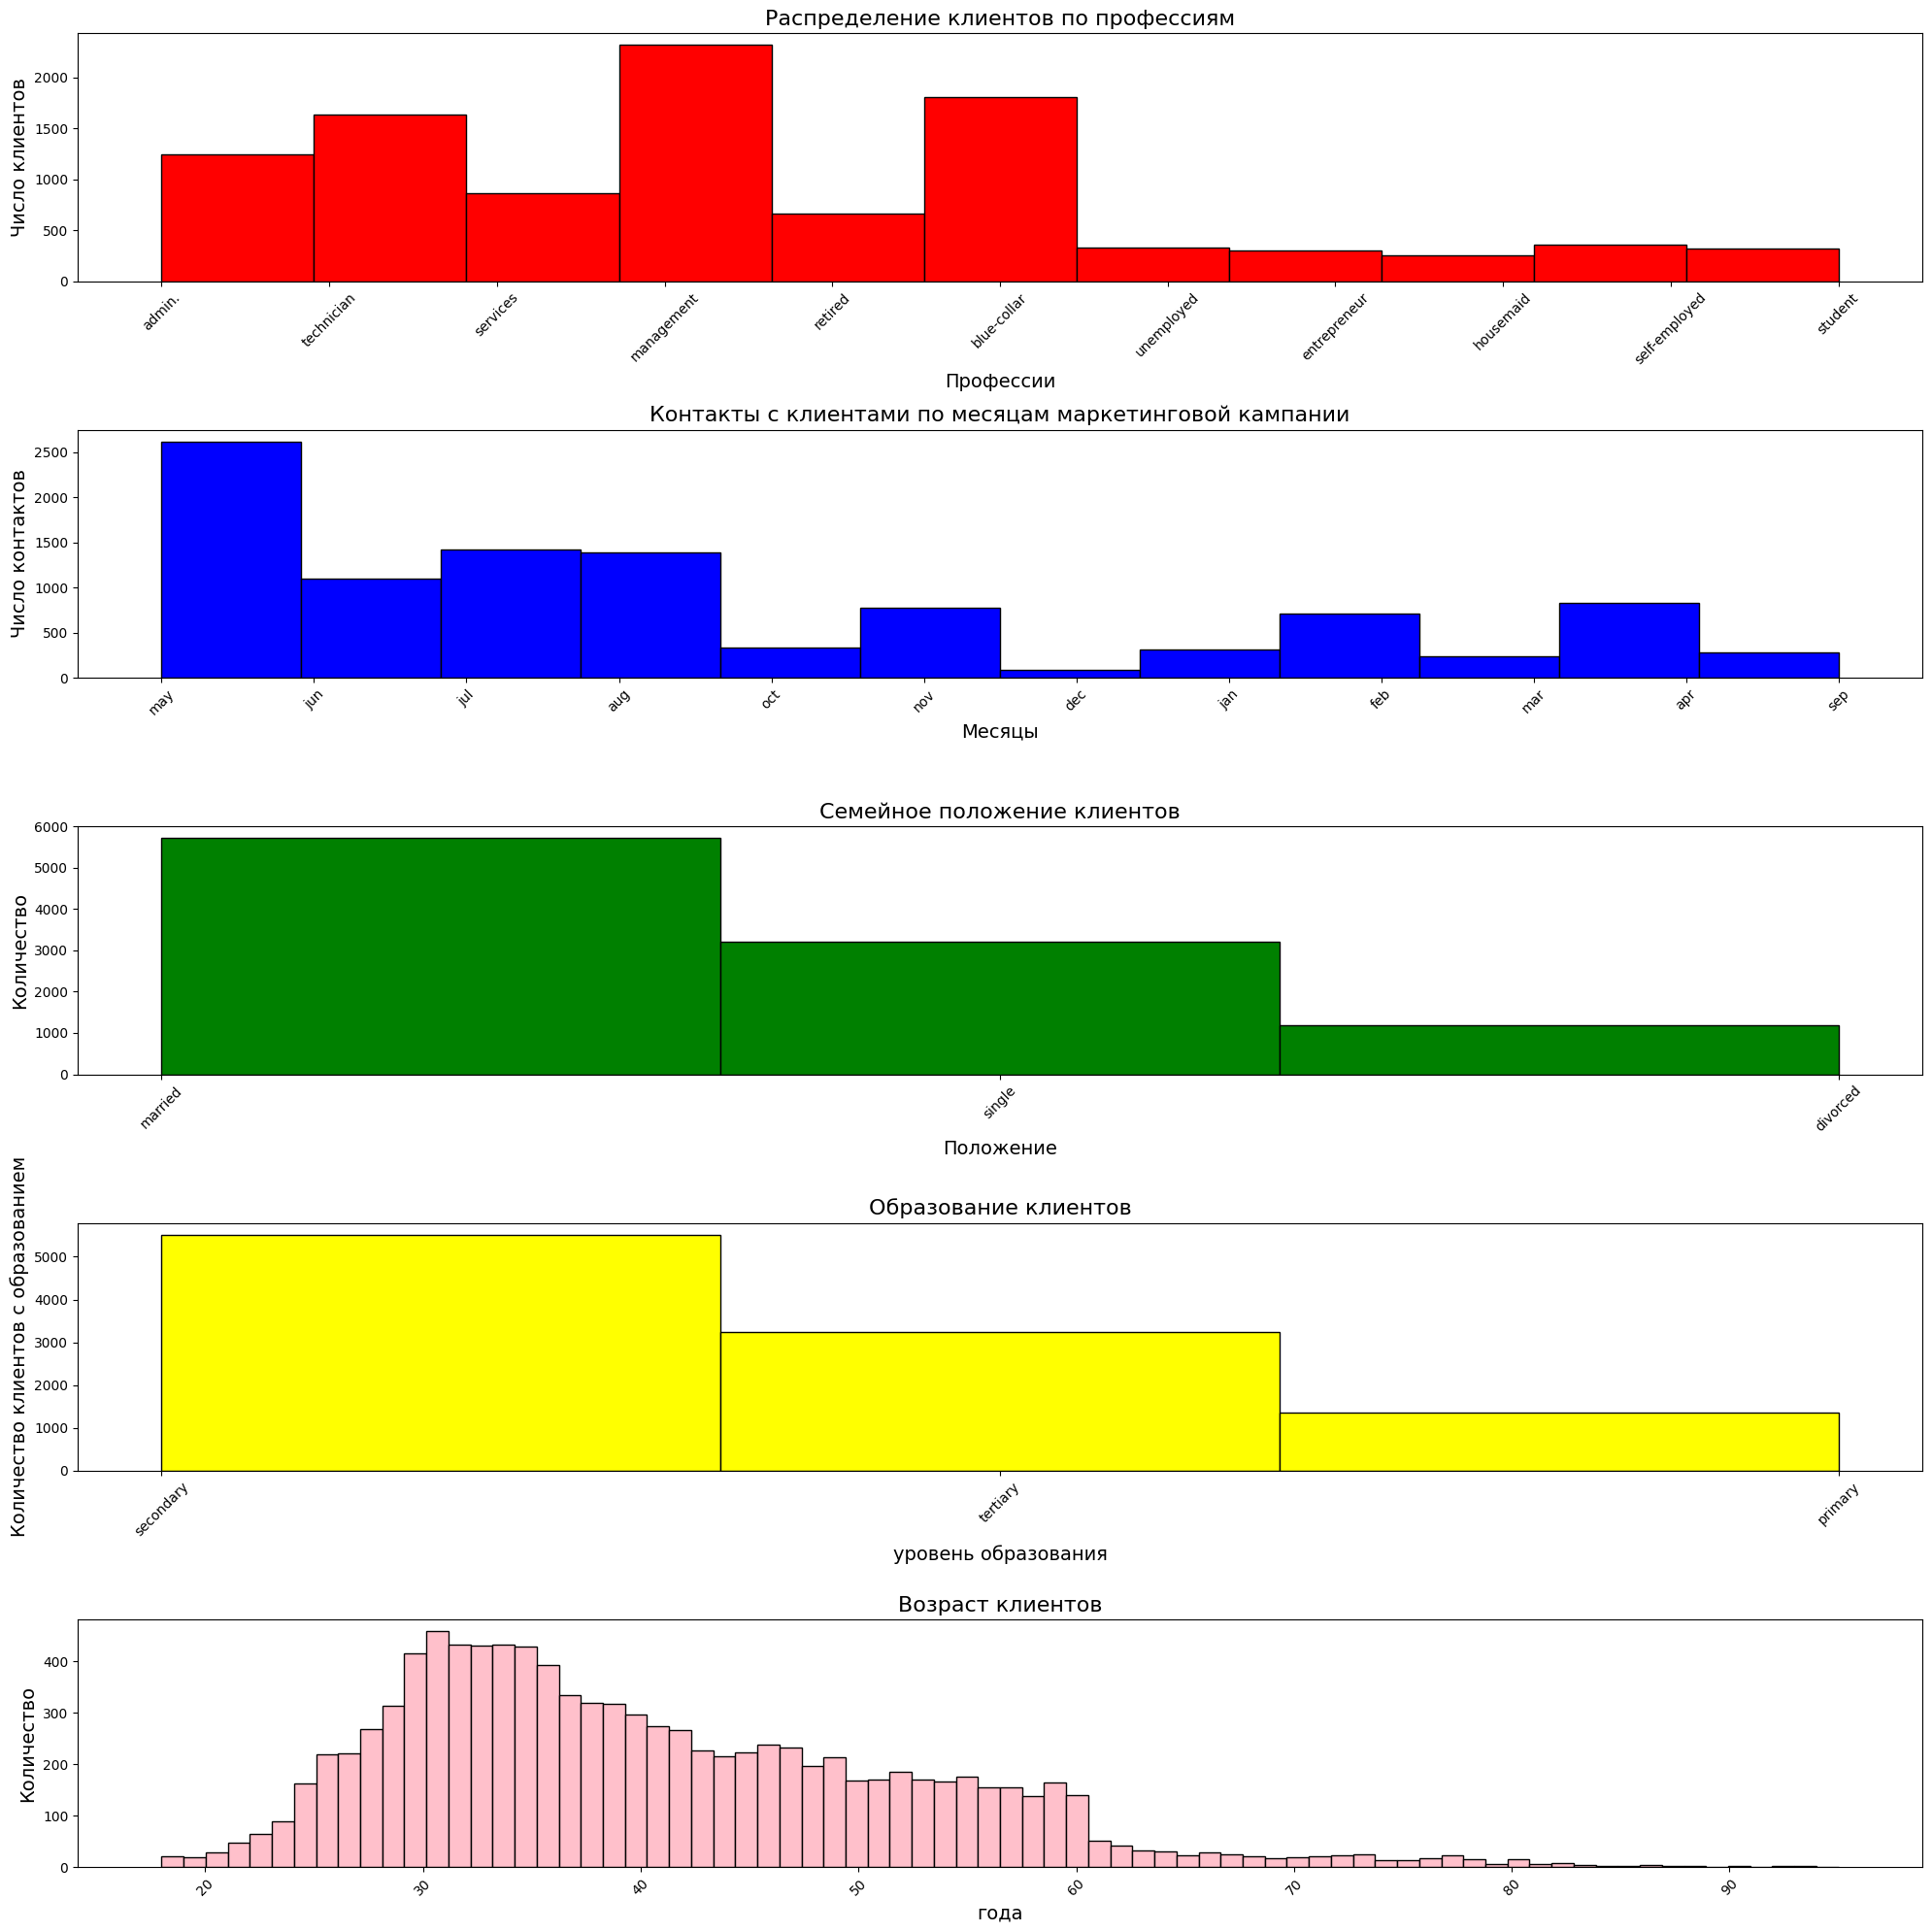

In [133]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат

print('Количество сфер занятости клиентов: {}'.format
    (df_nb['job'].nunique()))
print('месяцы в которые проводилась маркетинговая компания: {}'.format
    (df_nb['month'].value_counts()))
print('Cемейное положение клиентов: {}'.format
    (df_nb['marital'].value_counts()))
print('Образование клиентов: {}'.format
    (df_nb['education'].value_counts()))
print('Средний возраст клиентов: {}'.format
    (round(df_nb['age'].mean(), 0)))

# Создаем фигуру и оси
fig, axes = plt.subplots(5, 1, figsize=(20, 20))

# Визуализация распределения по профессиям (job)
axes[0].hist(df_nb['job'], color='red', edgecolor='black', bins=len(df_nb['job'].unique()))
axes[0].set_title('Распределение клиентов по профессиям', fontsize=16)
axes[0].set_xlabel('Профессии', fontsize=14)
axes[0].set_ylabel('Число клиентов', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Визуализация распределения контактов по месяцам (month)
axes[1].hist(df_nb['month'], color='blue', edgecolor='black', bins=12)
axes[1].set_title('Контакты с клиентами по месяцам маркетинговой кампании', fontsize=16)
axes[1].set_xlabel('Месяцы', fontsize=14)
axes[1].set_ylabel('Число контактов', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

# Визуализация распределения семейного положения клиентов (marital)
axes[2].hist(df_nb['marital'], color='green', edgecolor='black', bins=len(df_nb['marital'].unique()))
axes[2].set_title('Семейное положение клиентов', fontsize=16)
axes[2].set_xlabel('Положение', fontsize=14)
axes[2].set_ylabel('Количество', fontsize=14)
axes[2].tick_params(axis='x', rotation=45)

# Визуализация распределения образования клиентов (education)
axes[3].hist(df_nb['education'], color='yellow', edgecolor='black', bins=len(df_nb['education'].unique()))
axes[3].set_title('Образование клиентов', fontsize=16)
axes[3].set_xlabel('уровень образования', fontsize=14)
axes[3].set_ylabel('Количество клиентов с образованием', fontsize=14)
axes[3].tick_params(axis='x', rotation=45)

# Визуализация распределения образования клиентов (education)
axes[4].hist(df_nb['age'], color='pink', edgecolor='black', bins=len(df_nb['age'].unique()))
axes[4].set_title('Возраст клиентов', fontsize=16)
axes[4].set_xlabel('года', fontsize=14)
axes[4].set_ylabel('Количество', fontsize=14)
axes[4].tick_params(axis='x', rotation=45)

# Отображение графиков
plt.tight_layout()
plt.show()


### Задание 6

deposit     no   yes
poutcome            
failure    562   547
other      216   265
success     84   861
unknown   4562  3008


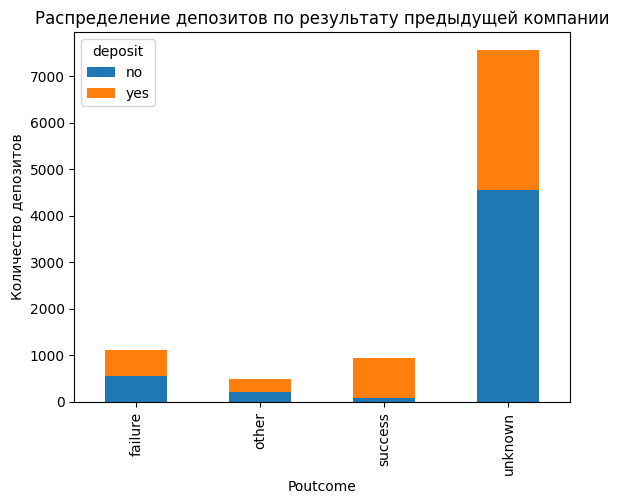

In [134]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
status_types = df_nb.groupby('poutcome')['deposit'].value_counts(normalize=False).unstack()
print(status_types)
status_types.plot(
    kind='bar',
    stacked='True'
)
plt.xlabel('Poutcome')
plt.ylabel('Количество депозитов')
plt.title('Распределение депозитов по результату предыдущей компании')
plt.show()

### Задание 7

In [135]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
status_types = df_nb.groupby('month')['deposit'].value_counts().unstack()
print(status_types)

deposit    no  yes
month             
apr       317  513
aug       775  610
dec         9   84
feb       323  386
jan       194  125
jul       836  582
jun       606  498
mar        24  213
may      1776  841
nov       456  324
oct        62  273
sep        46  232


In [136]:
for i in np.unique(df_nb.month):
    print(i, df_nb[(df_nb.month == i)&(df_nb.deposit == 'no')].shape[0]/df_nb[(df_nb.month == i)].shape[0])

apr 0.3819277108433735
aug 0.5595667870036101
dec 0.0967741935483871
feb 0.45557122708039494
jan 0.6081504702194357
jul 0.5895627644569816
jun 0.5489130434782609
mar 0.10126582278481013
may 0.6786396637371036
nov 0.5846153846153846
oct 0.18507462686567164
sep 0.16546762589928057


### Задание 8

<Axes: xlabel='age_group', ylabel='count'>

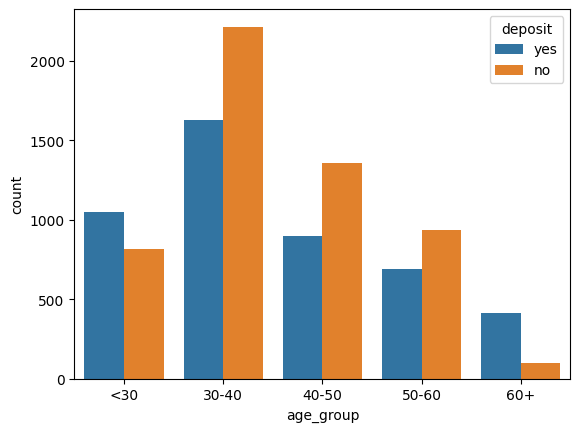

In [137]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df_nb['age_group'] = pd.cut(df_nb.age, [0, 30, 40, 50, 60, 999],
                            labels=['<30', '30-40', '40-50', '50-60', '60+'])
sns.countplot(x='age_group',
              hue='deposit',
              data=df_nb)

Из анализа графика можно сделать следующие выводы:

- большинство клиентов банка от 18 до 50 лет
- в возрасте 30 и меньше лет и 60+ больше всего согласились на депозит
- в возрастах от 30 и до 60 Многие люди отказались от депозита

### Задания 9 и 10

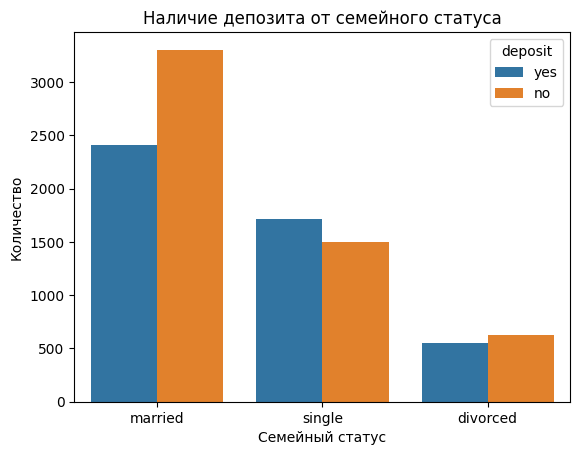

In [138]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig, axes = plt.subplots()
sns.countplot(
    data=df_nb,
    x='marital',
    hue='deposit'
)
plt.xlabel('Семейный статус')
plt.ylabel('Количество')
plt.title('Наличие депозита от семейного статуса')
plt.show()

Из анализа графика можно делать выводы:

- Большинство клиентов банка имеют статус - женаты
- Одинокие клиенты, чаще соглашаются на депозит
- Женатые и разведенные клиенты, чаще отказываются от депозита

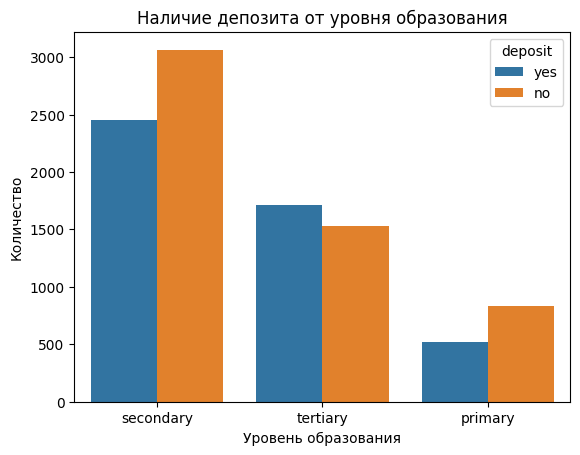

In [139]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig, axes = plt.subplots()
sns.countplot(
    data=df_nb,
    x='education',
    hue='deposit'
)
plt.xlabel('Уровень образования')
plt.ylabel('Количество')
plt.title('Наличие депозита от уровня образования')
plt.show()

Из анализа графика можно сделать следующие выводы:

- большинство клиентов имеют среднее образование
- Клиенты с высшим образованием чаще соглашаются на депозит
- Клиенты с начальным и среднем образованием чаще отказываются от депозита

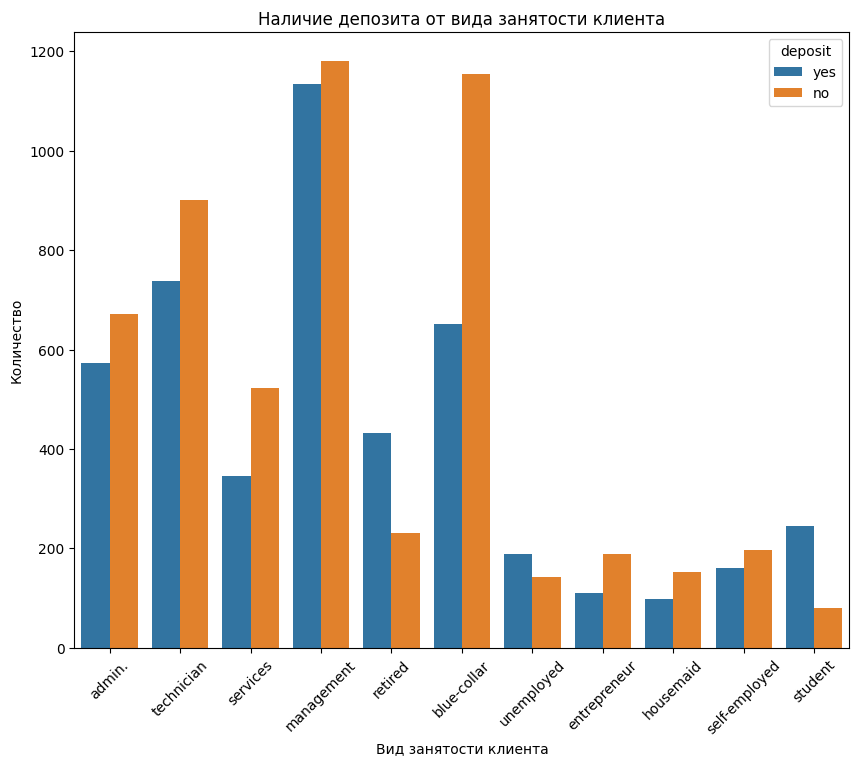

In [140]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig, axes = plt.subplots(figsize=(10, 8))
sns.countplot(
    data=df_nb,
    x='job',
    hue='deposit'
)
plt.xlabel('Вид занятости клиента')
plt.ylabel('Количество')
plt.title('Наличие депозита от вида занятости клиента')
plt.xticks(rotation=45)
plt.show()

Из анализа графика можно сделать следующие выводы:

- Большиство клиентов работают в сфере: менеджмента, технологии и рабочего класса
- Студенты, Безработные и пенсионеры чаще всего соглашаются на депозит
- Клиенты в остальных сферах занятости чаще отказываются от депозита

### Задание 11

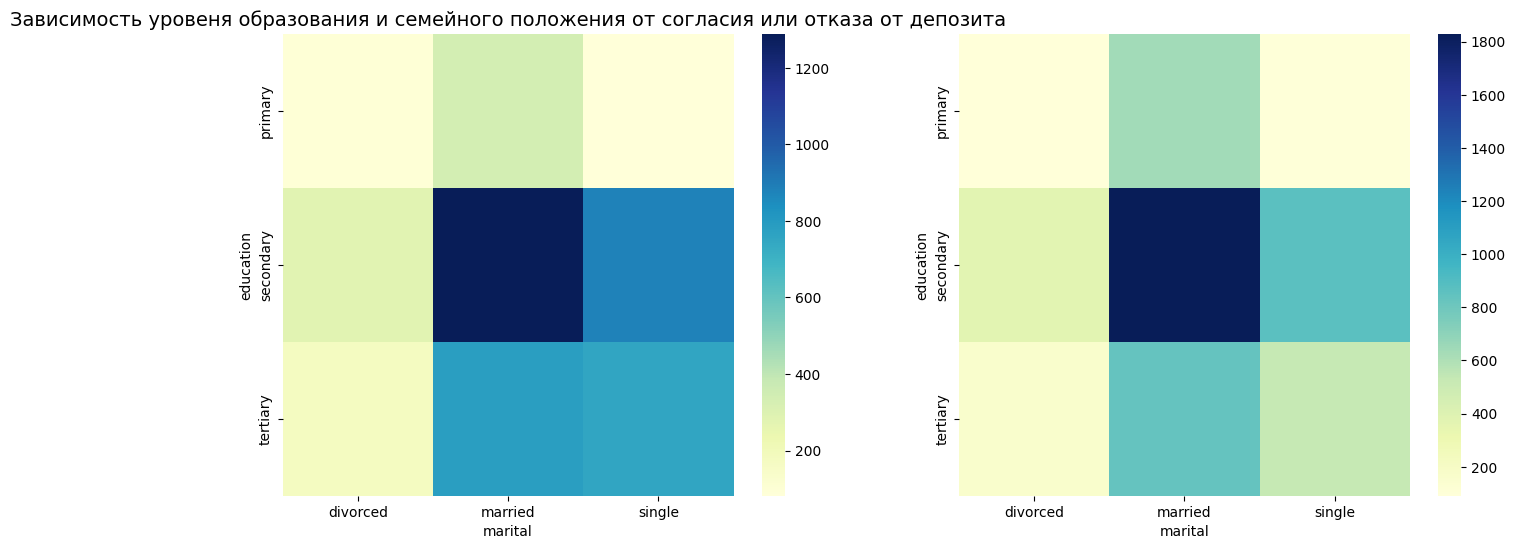

In [141]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_no=df_nb[df_nb['deposit']=='no']
df_yes=df_nb[df_nb['deposit']=='yes']

pivot_no=df_no.pivot_table(
    values='deposit',
    index='education',
    columns='marital',
    aggfunc='count'
)

pivot_yes=df_yes.pivot_table(
    values='deposit',
    index='education',
    columns='marital',
    aggfunc='count'
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

heatmap_yes = sns.heatmap(
    data=pivot_yes,
    cmap='YlGnBu',
    ax= axes[0]
)

heatmap_yes.set_title('Зависимость уровеня образования и семейного положения от согласия или отказа от депозита',
                      fontsize=14);

heatmap_no = sns.heatmap(
    data=pivot_no,
    cmap='YlGnBu',
    ax= axes[1]
);

## Часть 3: преобразование данных

In [142]:
df_nb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        10105 non-null  int64   
 1   job        10105 non-null  object  
 2   marital    10105 non-null  object  
 3   education  10105 non-null  object  
 4   default    10105 non-null  object  
 5   balance    10105 non-null  float64 
 6   housing    10105 non-null  object  
 7   loan       10105 non-null  object  
 8   contact    10105 non-null  object  
 9   day        10105 non-null  int64   
 10  month      10105 non-null  object  
 11  duration   10105 non-null  int64   
 12  campaign   10105 non-null  int64   
 13  pdays      10105 non-null  int64   
 14  previous   10105 non-null  int64   
 15  poutcome   10105 non-null  object  
 16  deposit    10105 non-null  object  
 17  age_group  10105 non-null  category
dtypes: category(1), float64(1), int64(6), object(10)
memory usage: 1.4+ MB


### Задание 1

In [143]:
# преобразуйте уровни образования
le = LabelEncoder()

df_nb['education'] = le.fit_transform(df_nb['education'])
df_nb['education'].sum()


11995

### Задания 2 и 3

In [144]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df_nb['age_group'] = le.fit_transform(df_nb['age_group'])

In [145]:
df_nb['deposit'] = df_nb['deposit'].apply(lambda x:1 if x=='yes' else 0)
df_nb['default'] = df_nb['default'].apply(lambda x:1 if x=='yes' else 0)
df_nb['housing'] = df_nb['housing'].apply(lambda x:1 if x=='yes' else 0)
df_nb['loan'] = df_nb['loan'].apply(lambda x:1 if x=='yes' else 0)

In [146]:
deposit_std = round(df_nb["deposit"].std(),3)
default_mean = df_nb['default'].mean()
housing_mean = df_nb['housing'].mean()
loan_mean = df_nb['loan'].mean()
sum_mean = round((default_mean + housing_mean + loan_mean), 3)
print(f'Стандартное отклонение deposit составляет: {deposit_std}')
print(f'Сумма средних арифмитических составляет: {sum_mean}')

Стандартное отклонение deposit составляет: 0.499
Сумма средних арифмитических составляет: 0.635


### Задание 4

In [147]:
# создайте дамми-переменные
df_dum = pd.get_dummies(df_nb, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

In [148]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  bool   
 14  job_blue-collar    10105 non-null  bool   
 15  job_entrepreneur   10105 non-null  bool   
 16  job_housemaid      10105 no

### Задания 5 и 6

Наиболее высокая корреляция между признаками:


,level_0,level_1,0
1361,contact_unknown,contact_cellular,0.837885
459,pdays,poutcome_unknown,0.824031
1176,marital_married,marital_single,0.779038
505,previous,poutcome_unknown,0.628346
1941,poutcome_failure,pdays,0.608719
2112,poutcome_unknown,poutcome_failure,0.606736
2069,poutcome_success,poutcome_unknown,0.555044
18,age,job_retired,0.545524
63,education,job_management,0.518735
424,pdays,previous,0.513708


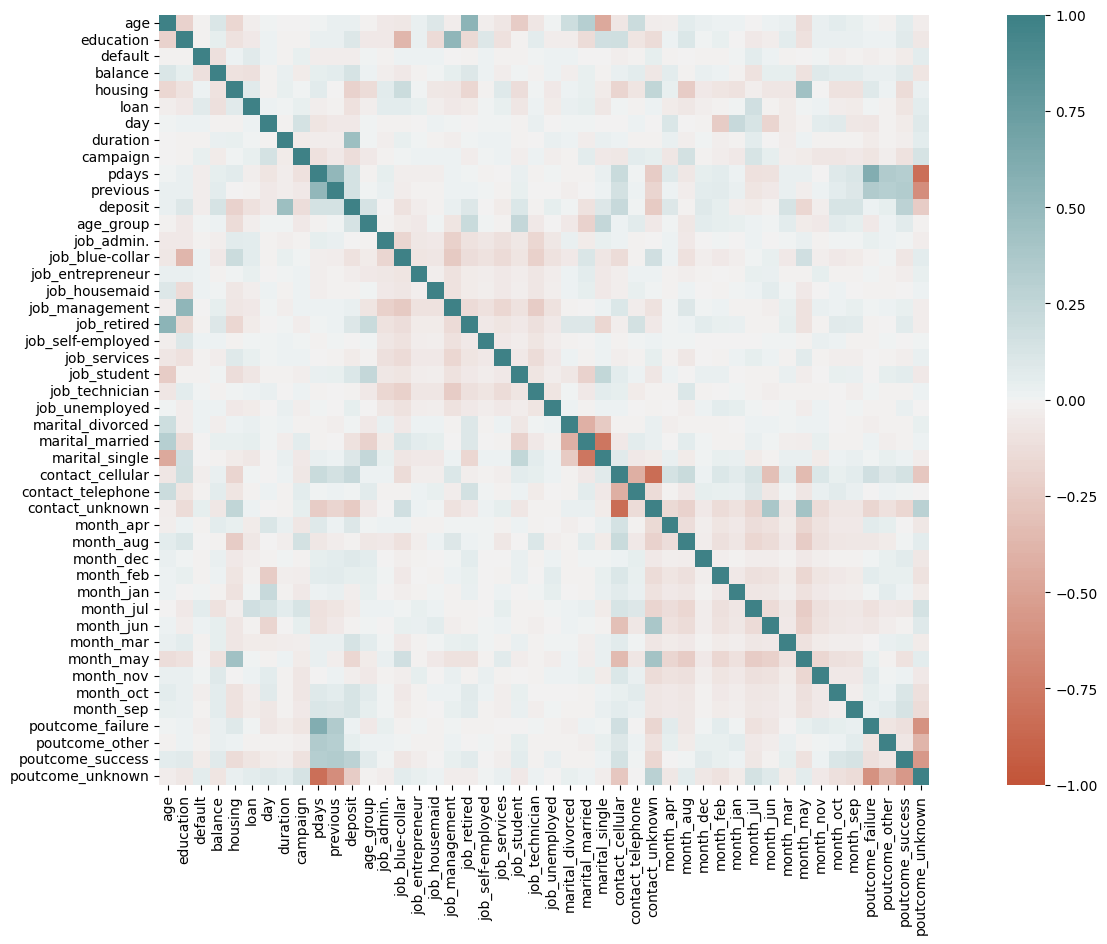

In [149]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr_df = df_dum.corr()
fig, axes = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(
    corr_df,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 200, n=200),
    square=True
);

print('Наиболее высокая корреляция между признаками:')
corr_unstack = corr_df.abs().unstack().reset_index()
corr_unstack = corr_unstack.sort_values(by=[0], ascending=False)
mask = corr_unstack['level_0'] != corr_unstack['level_1']
corr_unstack = corr_unstack[mask]
corr_unstack['pr1'] = corr_unstack['level_0'] + corr_unstack['level_1']
corr_unstack['pr1'] = corr_unstack['pr1'].apply(lambda x: ''.join(sorted(list(x))))
corr_unstack = corr_unstack.drop_duplicates(subset=['pr1'])
corr_unstack = corr_unstack.drop(['pr1'], axis=1)
corr_unstack.iloc[:40, :]

### Задания 7 и 8

In [150]:
X = df_dum.drop(['deposit'], axis=1)
y = df_dum['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [151]:
# рассчитайте необходимые показатели
print(X_train.shape, X_test.shape)
print(round(y_test.mean(),2))

(6770, 45) (3335, 45)
0.46


### Задание 9

In [152]:
from sklearn.feature_selection import SelectKBest, f_classif

# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [153]:
df = df_dum[['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'age_group', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 10

In [154]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

print(round(X_test_scaler[: , 0].mean(), 2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [155]:
# обучите логистическую регрессию и рассчитайте метрики качества
lgr = linear_model.LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000
)

lgr.fit(X_train_scaler, y_train)

# Метрики
print('Метрика accuracy на обучающем наборе: {:.2f}'.format(lgr.score(X_train_scaler, y_train)))
print('Метрика accuracy на тестовом наборе: {:.2f}'.format(lgr.score(X_test_scaler, y_test)))


Метрика accuracy на обучающем наборе: 0.82
Метрика accuracy на тестовом наборе: 0.81


### Задания 2,3,4

In [156]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

dt.fit(X_train_scaler, y_train)

# Метрики
print('Метрика accuracy на обучающем наборе: {:.2f}'.format(dt.score(X_train_scaler, y_train)))
print('Метрика accuracy на тестовом наборе: {:.2f}'.format(dt.score(X_test_scaler, y_test)))

Метрика accuracy на обучающем наборе: 1.00
Метрика accuracy на тестовом наборе: 0.75


In [157]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=6
)

dt.fit(X_train_scaler, y_train)

# Метрики
print('Метрика accuracy на обучающем наборе: {:.2f}'.format(dt.score(X_train_scaler, y_train)))
print('Метрика accuracy на тестовом наборе: {:.2f}'.format(dt.score(X_test_scaler, y_test)))

Метрика accuracy на обучающем наборе: 0.82
Метрика accuracy на тестовом наборе: 0.81


In [158]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 7
)

dt.fit(X_train_scaler, y_train)

# Выводим значения метрики 
print("accuracy_7 на обучающем наборе: {:.2f}".format(dt.score(X_train_scaler, y_train)))
print("accuracy_7 на тестовом наборе: {:.2f}".format(dt.score(X_test_scaler, y_test)))

accuracy_7 на обучающем наборе: 0.84
accuracy_7 на тестовом наборе: 0.81


### Задание 5

In [159]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
}

grid_search_cv = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        random_state=42),
    param_grid=param_grid,
    scoring='f1',
    return_train_score=True,
    cv=5,
    n_jobs=-1    
)

%time grid_search_cv.fit(X_train_scaler, y_train)

print('Best score is: {:.6f}'.format(grid_search_cv.best_score_))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_cv.best_params_))

CPU times: total: 78.1 ms
Wall time: 486 ms
Best score is: 0.799279
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [160]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

rf.fit(X_train_scaler, y_train)

y_train_pred = rf.predict(X_train_scaler)
print('Accuracy and recall train model:\n {}'.format(metrics.classification_report(y_train_pred, y_train)))

y_test_pred = rf.predict(X_test_scaler)
print('Accuracy and recall test model:\n {}'.format(metrics.classification_report(y_test_pred, y_test)))

Accuracy and recall train model:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      3556
           1       0.86      0.84      0.85      3214

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Accuracy and recall test model:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84      1728
           1       0.83      0.80      0.82      1607

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [161]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

gb.fit(X_train_scaler, y_train)

y_test_pred = gb.predict(X_test_scaler)
print('F1 score in test model: {:.2f}'.format(metrics.f1_score(y_test_pred, y_test)))

F1 score in test model: 0.82


### Задание 4

In [162]:
# объедините уже известные вам алгоритмы с помощью стекинга
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

%time stack.fit(X_train_scaler, y_train)
# Формируем предсказание для тестовой выборки
y_test_pred_stack = stack.predict(X_test_scaler)
# Выводим отчет о метриках
print('Metrics test model:\n {}'.format(metrics.classification_report(y_test_pred_stack, y_test)))

CPU times: total: 6.33 s
Wall time: 18.8 s
Metrics test model:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1788
           1       0.81      0.81      0.81      1547

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [163]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=3)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

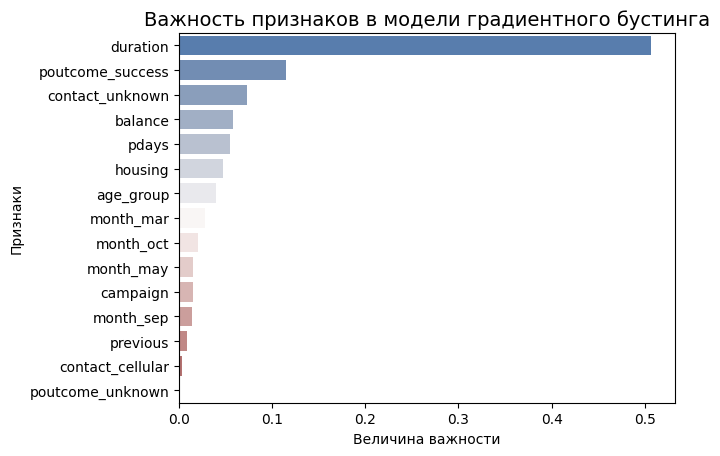

In [164]:
gb_feat = pd.Series(stack.named_estimators_['gb'].feature_importances_,
                    index=X_train.columns).sort_values(ascending=False)

# Построим диаграмму, иллюстрирующую важность признаков в модели
barplot = sns.barplot(
    data = gb_feat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);

barplot.set_title('Важность признаков в модели градиентного бустинга', fontsize = 14);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

### Задания 6,7,8

In [165]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    model.fit(X_train_scaler, y_train)
    score = metrics.f1_score(y_test, model.predict(X_test_scaler))
    
    return score

In [172]:
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study.optimize(optuna_rf, n_trials=20)

[I 2024-08-13 08:56:24,175] A new study created in memory with name: RandomForestClassifier
[I 2024-08-13 08:56:24,815] Trial 0 finished with value: 0.8188131313131313 and parameters: {'n_estimators': 112, 'max_depth': 20, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8188131313131313.
[I 2024-08-13 08:56:25,793] Trial 1 finished with value: 0.813731722822632 and parameters: {'n_estimators': 174, 'max_depth': 12, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8188131313131313.
[I 2024-08-13 08:56:27,140] Trial 2 finished with value: 0.8245283018867925 and parameters: {'n_estimators': 191, 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8245283018867925.
[I 2024-08-13 08:56:28,381] Trial 3 finished with value: 0.8195275590551181 and parameters: {'n_estimators': 172, 'max_depth': 20, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8245283018867925.
[I 2024-08-13 08:56:28,973] Trial 4 finished with value: 0.8195060164661178 and parameters: {'n_e

In [173]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 191, 'max_depth': 15, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.82


In [174]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=42,)
model.fit(X_train_scaler, y_train)
y_train_pred = model.predict(X_train_scaler)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaler, y_test)))
y_test_pred = model.predict(X_test_scaler)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82
